# Use of foscat to forecast ECMWF global information

This notebook ....

## TODO:

- Problem while using statistics of the previous timestep, should compress dimensinality of foscat

## Installation of required packages

In [1]:
#!pip install foscat==3.1.0 
#!pip install --upgrade "xarray<=2025.4.0"

In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import foscat.scat_cov as sc
import foscat.Synthesis as synthe

### Choose the resolution

In [3]:
nside=32

In [4]:
import gcsfs
import xarray
gcs = gcsfs.GCSFileSystem(token='anon')

era5_path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
full_era5 = xarray.open_zarr(gcs.get_mapper(era5_path), chunks=None)
full_era5

<xarray.Dataset> Size: 4PB
Dimensions:                                                          (
                                                                      time: 1323648,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * latitude                                                         (latitude) float32 3kB ...
  * level                                                            (level) int64 296B ...
  * longitude                                                        (longitude) float32 6kB ...
  * time                                                             (time) datetime64[ns] 11MB ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 5TB ...
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 5TB ...
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB ...
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 5TB ...
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB ...
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 5TB ...
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 5TB ...
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 5TB ...
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 5TB ...
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 5TB ...
    wave_spectral_skewness                                           (time, latitude, longitude) float32 5TB ...
    zero_degree_level                                                (time, latitude, longitude) float32 5TB ...
Attributes:
    last_updated:           2025-09-29 01:55:09.136848+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-04-30
    valid_time_stop_era5t:  2025-09-23

In [5]:
temperature=full_era5['sea_surface_temperature'] # the nearest from the surface
temperature

<xarray.DataArray 'sea_surface_temperature' (time: 1323648, latitude: 721,
                                             longitude: 1440)> Size: 5TB
[1374264299520 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 11MB 1900-01-01 ... 2050-12-31T23:00:00
Attributes:
    long_name:   Sea surface temperature
    short_name:  sst
    units:       K

In [6]:
tisr=full_era5['toa_incident_solar_radiation']
tisr

<xarray.DataArray 'toa_incident_solar_radiation' (time: 1323648, latitude: 721,
                                                  longitude: 1440)> Size: 5TB
[1374264299520 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 11MB 1900-01-01 ... 2050-12-31T23:00:00
Attributes:
    long_name:   TOA incident solar radiation
    short_name:  tisr
    units:       J m**-2

In [7]:
from scipy.interpolate import RegularGridInterpolator

# convert the input data in a nside=nside healpix map based on repixelisation at l_nside
def to_Healpix(arr_val,itime,nside,l_nside=512):
    
    latitude=(90.0-arr_val.latitude.compute().to_numpy())/180.*np.pi
    longitude=(360.0-arr_val.longitude.compute().to_numpy())/180.*np.pi
    im=arr_val.isel(time=itime).compute().to_numpy()
    xsize,ysize=im.shape

    # Define the new row and column to be added to prepare the interpolation
    new_row = im[0:1,:]  # A new row with N elements (the other longitude)
    new_column = np.concatenate([im[:,0:1],im[-2:-1,0:1]],0)  # A new column with N+1 elements to add previous latitude

    # Add the new row to the array
    im = np.vstack([im, new_row])
    longitude = np.concatenate([longitude,2*longitude[-1:]-longitude[-2:-1]],0)
    latitude = np.concatenate([latitude,2*latitude[-1:]-latitude[-2:-1]],0)

    # Add the new column to the array with the new row
    im = np.hstack([im, new_column])

    # Create an interpolator
    interpolator = RegularGridInterpolator((latitude,longitude), im)

    # List of healpix coordinate to interpol
    colatitude,longitude = hp.pix2ang(l_nside,np.arange(12*l_nside**2),nest=True)
    coords = np.concatenate([colatitude,longitude],0).reshape(2,colatitude.shape[0]).T

    # Perform the interpolation
    heal_im = interpolator(coords)

    #reduce the final map to the expected resolution
    if nside>l_nside:
        th,ph=hp.pix2ang(nside,np.arange(12*nside**2),nest=True)
        heal_im=hp.get_interp_val(heal_im,th,ph,nest=True)
    else:
        heal_im=np.mean(heal_im.reshape(12*nside**2,(l_nside//nside)**2),1)

    return heal_im

In [8]:
ntest=1000
nvalid=ntest

try:
    train_im=np.load('/home/jovyan/NEWDEMO/demo-foscat-pangeo-eosc/train_im_%d.npy'%(ntest))
    train_sun=np.load('/home/jovyan/NEWDEMO/demo-foscat-pangeo-eosc/train_sun_%d.npy'%(ntest))
except:
    train_im=np.zeros([ntest,12*nside**2])
    train_sun=np.zeros([ntest,12*nside**2])

    for k in range(ntest):
        print('test ',k,train_im[k,100])
        train_im[k]=to_Healpix(temperature,1000000+24*k,nside)
        train_sun[k]=to_Healpix(tisr,1000000+24*k,nside)
    
    np.save('train_im_%d.npy'%(ntest),train_im)
    np.save('train_sun_%d.npy'%(ntest),train_sun)

try:
    valid_im=np.load('/home/jovyan/NEWDEMO/demo-foscat-pangeo-eosc/valid_im_%d.npy'%(ntest))
    valid_sun=np.load('/home/jovyan/NEWDEMO/demo-foscat-pangeo-eosc/valid_sun_%d.npy'%(ntest))
    
except:
    valid_im=np.zeros([nvalid,12*nside**2])
    valid_sun=np.zeros([nvalid,12*nside**2])
    
    for k in range(nvalid):
        print('valid ',k)
        valid_im[k]=to_Healpix(temperature,1000000+24*(ntest+k),nside)
        valid_sun[k]=to_Healpix(tisr,1000000+24*(ntest+k),nside)
    
    np.save('valid_im_%d.npy'%(ntest),valid_im)
    np.save('valid_sun_%d.npy'%(ntest),valid_sun)
print(train_im.shape,valid_im.shape)

(1000, 12288) (1000, 12288)


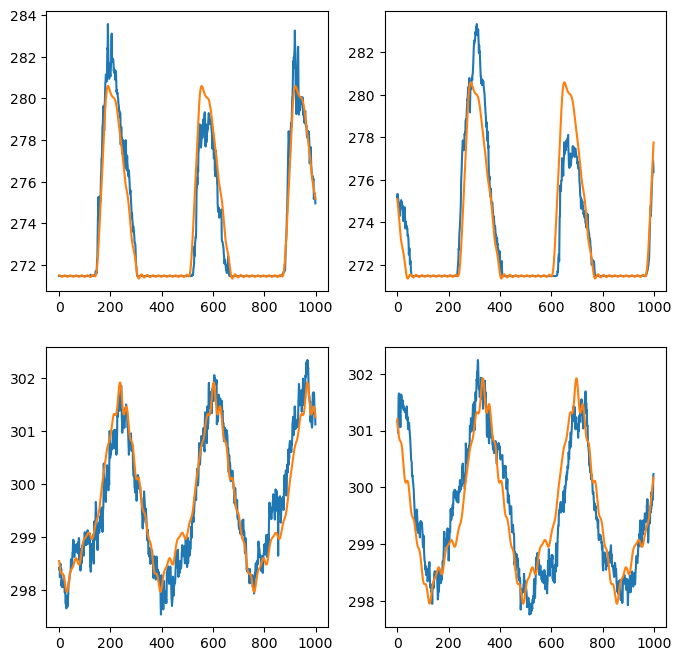

In [9]:
# Build a climato
nharm=16

tab=[np.ones([train_im.shape[0]])[None,:]]
for k in range(nharm):
    tab=tab+[np.cos((k+1)*2*np.pi*np.arange(train_im.shape[0])/365.25)[None,:],
              np.sin((k+1)*2*np.pi*np.arange(train_im.shape[0])/365.25)[None,:]]
train_day=np.concatenate(tab,0)
tab=[np.ones([valid_im.shape[0]])[None,:]]
for k in range(nharm):
    tab=tab+[np.cos((k+1)*2*np.pi*(np.arange(valid_im.shape[0])+train_im.shape[0])/365.25)[None,:],
              np.sin((k+1)*2*np.pi*(np.arange(valid_im.shape[0])+train_im.shape[0])/365.25)[None,:]]
valid_day=np.concatenate(tab,0)

mat_train=np.linalg.pinv(train_day@train_day.T)
mat_valid=np.linalg.pinv(valid_day@valid_day.T)

a=mat_train@(train_day@train_im)

train_clim=np.einsum('ij,ik->kj',a,train_day)
valid_clim=np.einsum('ij,ik->kj',a,valid_day)

plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.plot(train_im[:,500])
plt.plot(train_clim[:,500])
plt.subplot(2,2,2)
plt.plot(valid_im[:,500])
plt.plot(valid_clim[:,500])
plt.subplot(2,2,3)
plt.plot(train_im[:,50])
plt.plot(train_clim[:,50])
plt.subplot(2,2,4)
plt.plot(valid_im[:,50])
plt.plot(valid_clim[:,50])
plt.show()

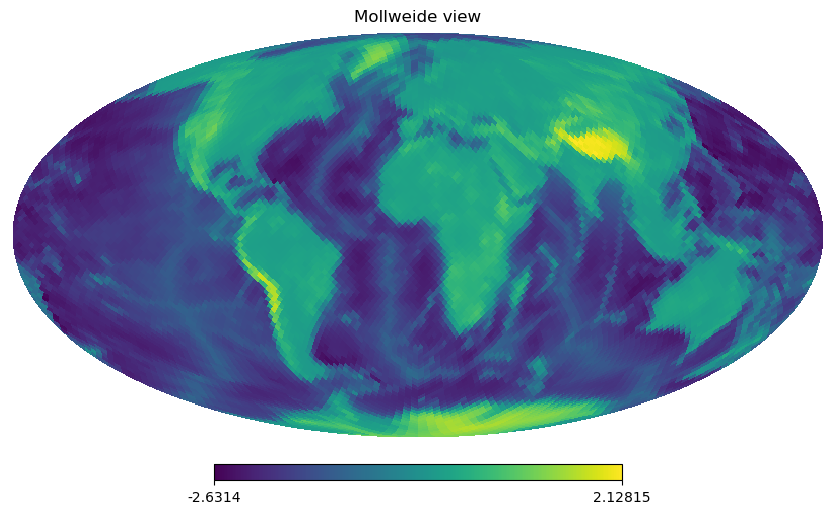

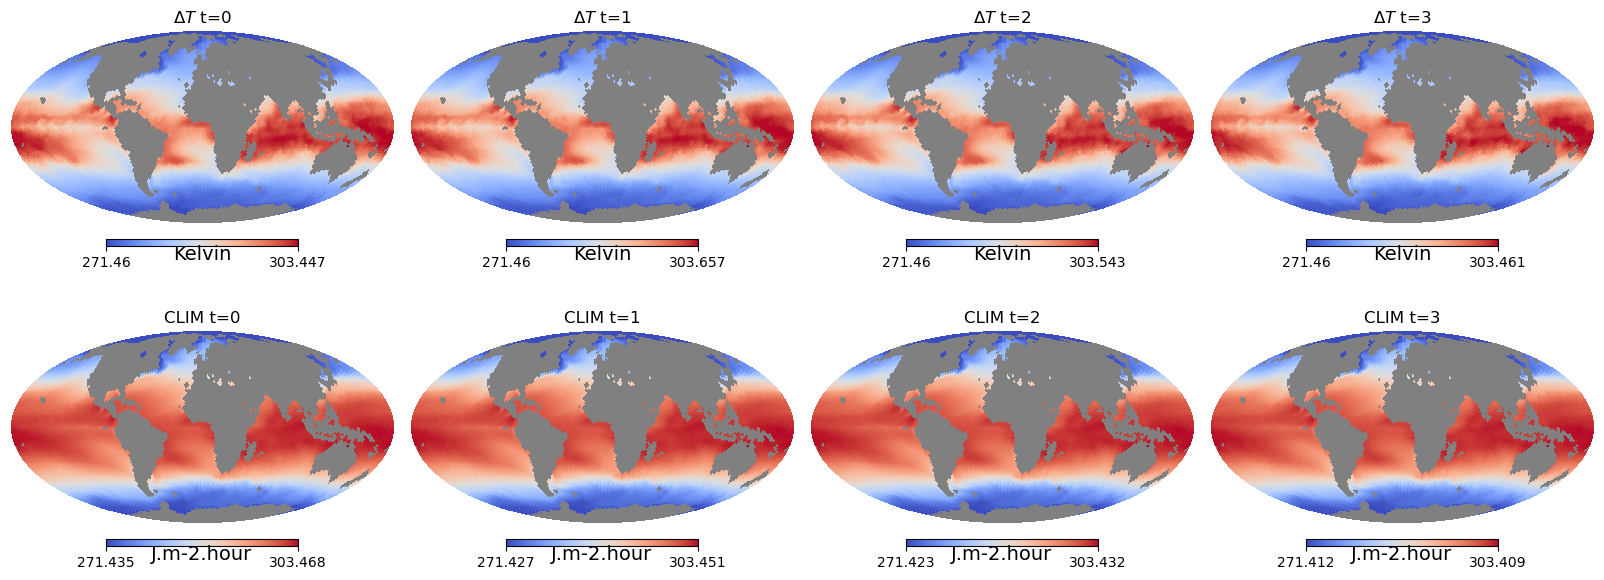

In [10]:
#im=hp.ud_grade(hp.read_map('/home/jovyan/Akathon-Geilo/Hack4RiOMAR/notebooks/GEBCO_2048.fits'),nside)
#np.save('DEM_%d.npy'%(nside),hp.reorder(im,r2n=True))
dem=np.load('/home/jovyan/NEWDEMO/demo-foscat-pangeo-eosc/DEM_%d.npy'%(nside))
dem=dem/np.std(dem)
t,p=hp.pix2ang(nside,np.arange(12*nside**2),nest=True)
pidx=hp.ang2pix(nside,t,-p,nest=True)
dem=dem[pidx]

hp.mollview(dem,nest=True)
plt.figure(figsize=(16,6))
nstep=4
for k in range(nstep):
    hp.mollview(train_im[k],nest=True,hold=False,sub=(2,nstep,1+k),cmap='coolwarm',norm='hist',title=r'$\Delta T$ t=%d'%(k),unit='Kelvin')
    hp.mollview(train_clim[k],nest=True,hold=False,sub=(2,nstep,1+nstep+k),cmap='coolwarm',title='CLIM t=%d'%(k),unit='J.m-2.hour')

In [11]:
cell_ids=np.where(np.isfinite(train_im[0]))[0]

def domap(x):
    im=np.ones([12*nside**2])*hp.UNSEEN
    im[cell_ids]=x
    return im

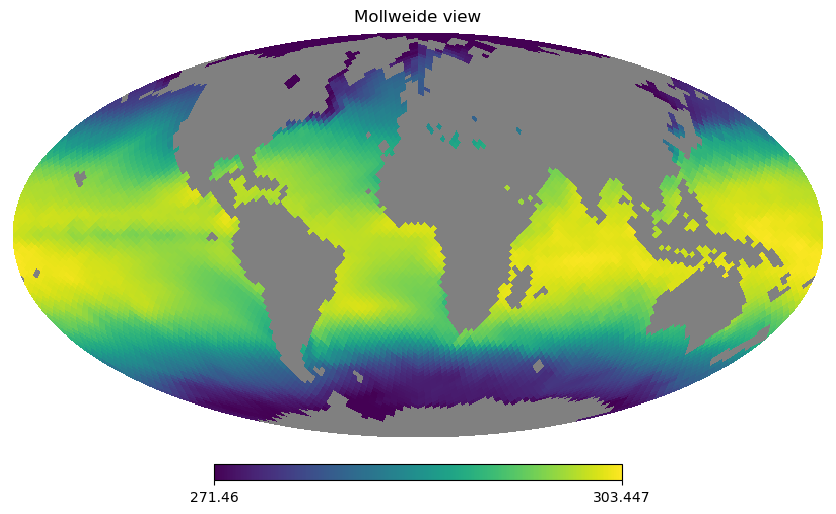

In [12]:
hp.mollview(domap(train_im[0,cell_ids]),nest=True)

In [13]:
from foscat.healpix_unet_torch import HealpixUNet,fit

nchan=8

model = HealpixUNet(
    in_nside=nside,
    n_chan_in=nchan,  # previous time step, tisr, DEM
    chanlist=[32*2**k for k in range(5)],
    gauge_type='phi',
    G=1,
    cell_ids=cell_ids,           # finest-resolution nested ids
    KERNELSZ=3,
    head_reduce='learned',
    task='regression',         # or 'regression' or 'segmentation'
    out_channels=1,              # e.g., #classes
    final_activation=None      # defaults: sigmoid if 1 class, else softmax; 'none' for regression
)

In [14]:
ampnorm=1/np.std(train_im[:,cell_ids])
amptisr=1/5E6

memory=[2**(k) for k in range(nchan-1)]
max_mem=np.max(memory)

# todo rappel pour rpedictibilité temporelle
#train_dem=np.tile(dem[cell_ids],ntest-max_mem-1).reshape(ntest-max_mem-1,1,cell_ids.shape[0])
#valid_dem=np.tile(dem[cell_ids],nvalid-max_mem-1).reshape(nvalid-max_mem-1,1,cell_ids.shape[0])
prev_dt=10
dt=max_mem

train_table=[ampnorm*(train_clim[max_mem+prev_dt:,None,cell_ids]-273)]
valid_table=[ampnorm*(valid_clim[max_mem+prev_dt:,None,cell_ids]-273)]
for k in memory:
    train_table=train_table+[ampnorm*(train_im[max_mem-k:-k-prev_dt,None,cell_ids]
                                      -train_clim[max_mem-k:-k-prev_dt,None,cell_ids])]
    valid_table=valid_table+[ampnorm*(valid_im[max_mem-k:-k-prev_dt,None,cell_ids]
                                      -valid_clim[max_mem-k:-k-prev_dt,None,cell_ids])]

x_train=model.to_tensor(np.concatenate(train_table,1))
y_train=model.to_tensor(ampnorm*(train_im[max_mem+prev_dt:,None,cell_ids]-train_clim[max_mem+prev_dt:,None,cell_ids]))

x_valid=model.to_tensor(np.concatenate(valid_table,1))
y_valid=model.to_tensor(ampnorm*(valid_im[max_mem+prev_dt:,None,cell_ids]-valid_clim[max_mem+prev_dt:,None,cell_ids]))
x_train.shape,y_train.shape

(torch.Size([926, 8, 7648]), torch.Size([926, 1, 7648]))

In [ ]:
print(ntest,x_train.shape)
# refine with LBFGS
hist  = fit(model, x_train,y_train, n_epoch=100, view_epoch=1,optimizer='ADAM',batch_size=10)

1000 torch.Size([926, 8, 7648])
[epoch 1] loss=0.017579
[epoch 2] loss=0.001297
[epoch 3] loss=0.001259
[epoch 4] loss=0.001236
[epoch 5] loss=0.001216
[epoch 6] loss=0.001202
[epoch 7] loss=0.001202
[epoch 8] loss=0.001198
[epoch 9] loss=0.001188
[epoch 10] loss=0.001181
[epoch 11] loss=0.001176
[epoch 12] loss=0.001168
[epoch 13] loss=0.001164
[epoch 14] loss=0.001166
[epoch 15] loss=0.001160
[epoch 16] loss=0.001133
[epoch 17] loss=0.001154
[epoch 18] loss=0.001113
[epoch 19] loss=0.001098
[epoch 20] loss=0.001092
[epoch 21] loss=0.001070
[epoch 22] loss=0.001094
[epoch 23] loss=0.001015
[epoch 24] loss=0.001010
[epoch 25] loss=0.001000
[epoch 26] loss=0.000982
[epoch 27] loss=0.000971
[epoch 28] loss=0.000928
[epoch 29] loss=0.000960
[epoch 30] loss=0.000883
[epoch 31] loss=0.000844
[epoch 32] loss=0.000846
[epoch 33] loss=0.000852
[epoch 34] loss=0.000864
[epoch 35] loss=0.000758
[epoch 36] loss=0.000850
[epoch 37] loss=0.000812
[epoch 38] loss=0.000773
[epoch 39] loss=0.000713
[e

In [16]:
y_pred=model.predict(x_train).cpu().numpy()+ampnorm*(train_clim[max_mem+prev_dt:,None,cell_ids]-273)
inv_norm=1/ampnorm
y_pred.shape


(926, 1, 7648)

0.14 0.11
0.18 0.12
0.19 0.11


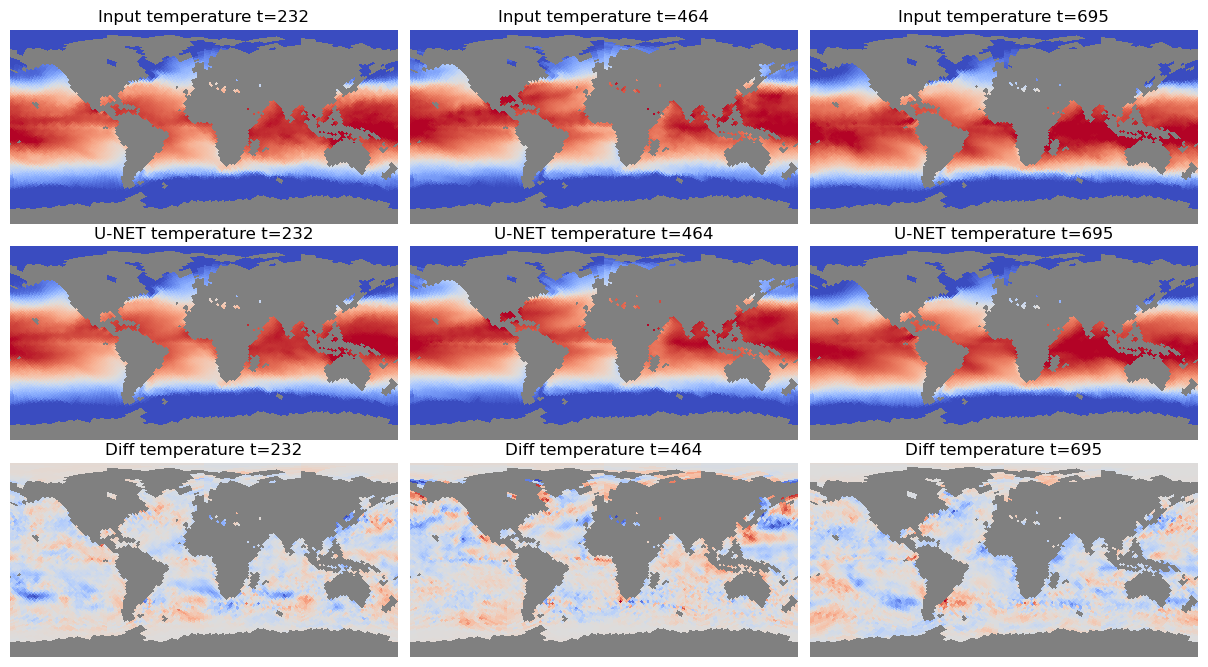

In [17]:
plt.figure(figsize=(12,6.5))
amp1=5
amp2=30
rot=[0,0]
nresult=y_pred.shape[0]
for i, k in enumerate([nresult//4, 2*nresult//4, 3*nresult//4]):
    hp.cartview(domap(inv_norm*(y_train)[k,0].cpu().numpy()+(train_clim[k+max_mem+prev_dt,cell_ids]-273)),
                rot=rot,cmap='coolwarm',nest=True,hold=False,sub=(3,3,1+i),min=amp1,max=amp2,cbar=False,title=r'Input temperature t=%d'%(k+1))
    hp.cartview(domap(inv_norm*y_pred[k,0]),rot=rot,cmap='coolwarm',
                nest=True,hold=False,sub=(3,3,4+i),min=amp1,max=amp2,cbar=False,
                title=r'U-NET temperature t=%d'%(k+1))
    hp.cartview(domap(inv_norm*(y_pred[k,0]-ampnorm*(train_clim[k+max_mem+prev_dt,cell_ids]-273)-y_train[k,0].cpu().numpy())),rot=rot,cmap='coolwarm',nest=True,hold=False,sub=(3,3,7+i),min=-2,max=2,cbar=False,title=r'Diff temperature t=%d'%(k+1))
    print("%.2f %.2f"%(np.sqrt(inv_norm*np.mean(y_train[k,0].cpu().numpy()**2)),
                       np.sqrt(inv_norm*np.mean((y_pred[k,0]-ampnorm*(train_clim[k+max_mem+prev_dt,cell_ids]-273)-y_train[k,0].cpu().numpy())**2))))

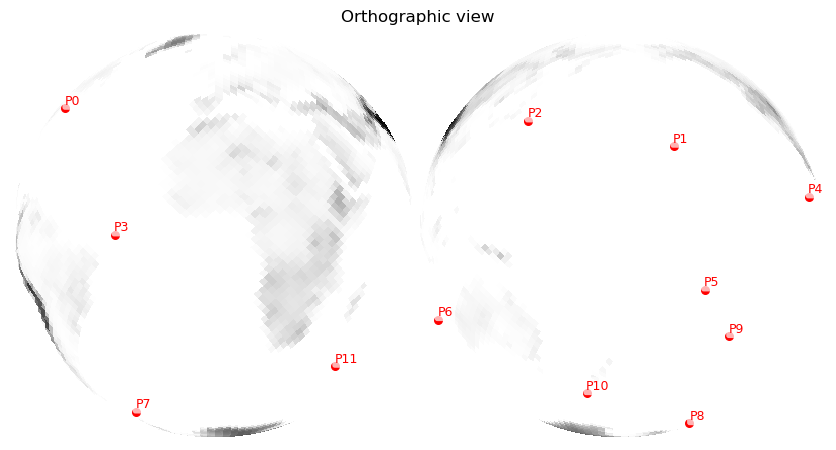

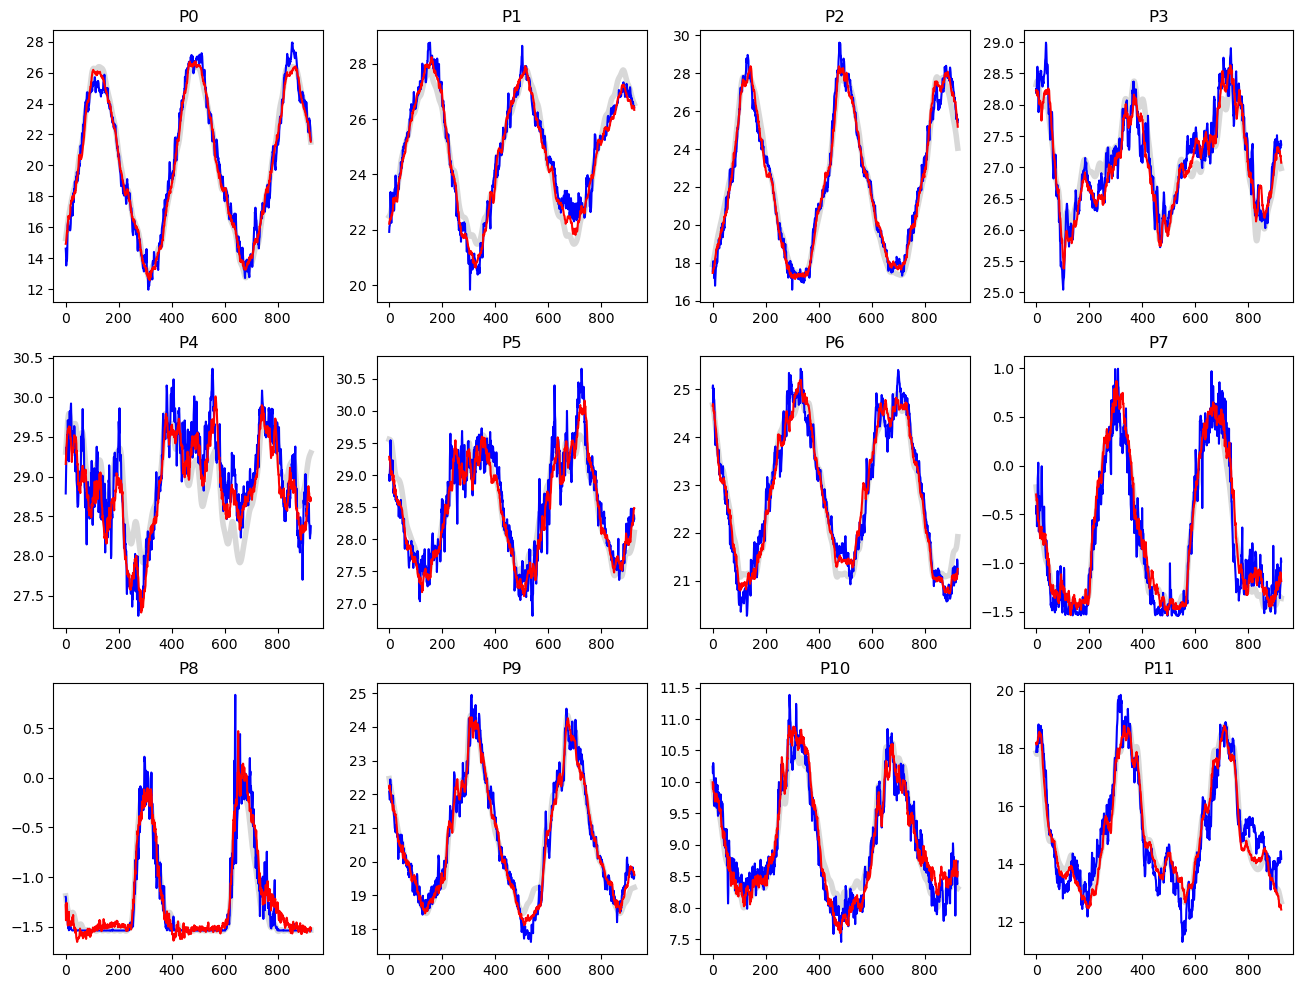

In [18]:
hp.orthview(dem,rot=rot,cmap='Greys',nest=True,min=0,cbar=False)

idx_k = ((2*np.arange(12)+1)*cell_ids.shape[0])//24

lon,lat=hp.pix2ang(nside,cell_ids[idx_k],nest=True,lonlat=True)
hp.projscatter(lon, lat, lonlat=True, s=30, color='r', marker='o')

# Étiquettes : une par point
labels = [f"P{k}" for k in range(len(lon))]  # ou tes propres noms
# petit décalage pour ne pas chevaucher le marqueur
dlon, dlat = 0.3, 0.3   # en degrés; ajuste si besoin

for x, y, lab in zip(lon, lat, labels):
    hp.projtext(x + dlon, y + dlat, lab, lonlat=True,
                fontsize=9, color='r',
                ha='left', va='bottom',
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7))
    
plt.figure(figsize=(16,12))
for k in range(12):
    plt.subplot(3,4,1+k)
    plt.title(labels[k])
    plt.plot((train_clim[max_mem+prev_dt:,cell_ids[idx_k[k]]]-273),color='grey',lw=4,alpha=0.3)
    plt.plot(inv_norm*y_train[:,0,idx_k[k]].cpu().numpy()+(train_clim[max_mem+prev_dt:,cell_ids[idx_k[k]]]-273),color='b')
    plt.plot(inv_norm*y_pred[:,0,idx_k[k]],color='r')

In [19]:
y_pred=model.predict(x_valid).cpu().numpy()+ampnorm*(valid_clim[max_mem+prev_dt:,None,cell_ids]-273)
inv_norm=1/ampnorm
y_pred.shape


(926, 1, 7648)

0.20 0.14
0.22 0.14
0.23 0.18


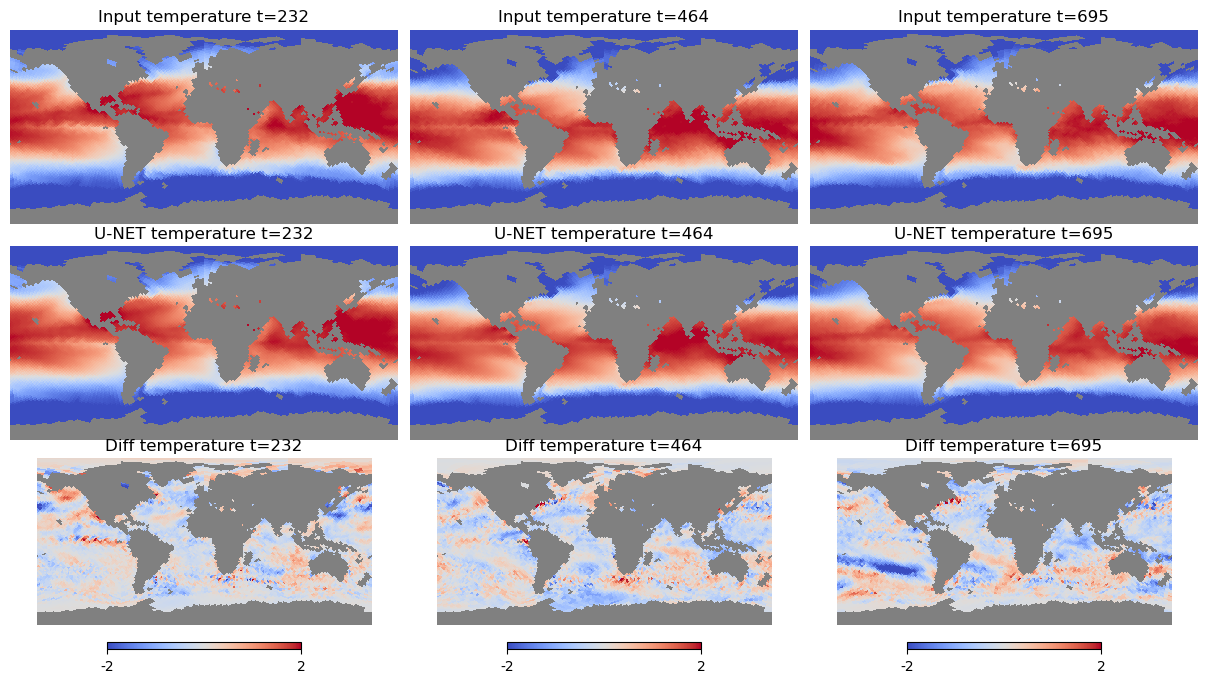

In [20]:
plt.figure(figsize=(12,6.5))
amp1=5
amp2=30
rot=[0,0]
nresult=y_pred.shape[0]
for i, k in enumerate([nresult//4, 2*nresult//4, 3*nresult//4]):
    hp.cartview(domap(inv_norm*(y_valid)[k,0].cpu().numpy()+(valid_clim[k+max_mem+prev_dt,cell_ids]-273)),rot=rot,cmap='coolwarm',nest=True,hold=False,sub=(3,3,1+i),min=amp1,max=amp2,cbar=False,title=r'Input temperature t=%d'%(k+1))
    hp.cartview(domap(inv_norm*y_pred[k,0]),rot=rot,cmap='coolwarm',
                nest=True,hold=False,sub=(3,3,4+i),min=amp1,max=amp2,cbar=False,title=r'U-NET temperature t=%d'%(k+1))
    hp.cartview(domap(inv_norm*(y_pred[k,0]-ampnorm*(valid_clim[k+max_mem+prev_dt,cell_ids]-273)-y_valid[k,0].cpu().numpy())),
                cbar=True,rot=rot,cmap='coolwarm',nest=True,hold=False,sub=(3,3,7+i),min=-2,max=2,title=r'Diff temperature t=%d'%(k+1))
    print("%.2f %.2f"%(np.sqrt(inv_norm*np.mean(y_valid[k,0].cpu().numpy()**2)),
                       np.sqrt(inv_norm*np.mean((y_pred[k,0]-ampnorm*(valid_clim[k+max_mem+prev_dt,cell_ids]-273)-y_valid[k,0].cpu().numpy())**2))))

In [ ]:
hp.orthview(dem,rot=rot,cmap='Greys',nest=True,min=0,cbar=False)

idx_k = ((2*np.arange(12)+1)*cell_ids.shape[0])//24

lon,lat=hp.pix2ang(nside,cell_ids[idx_k],nest=True,lonlat=True)
hp.projscatter(lon, lat, lonlat=True, s=30, color='r', marker='o')

# Étiquettes : une par point
labels = [f"P{k}" for k in range(len(lon))]  # ou tes propres noms
# petit décalage pour ne pas chevaucher le marqueur
dlon, dlat = 0.3, 0.3   # en degrés; ajuste si besoin

for x, y, lab in zip(lon, lat, labels):
    hp.projtext(x + dlon, y + dlat, lab, lonlat=True,
                fontsize=9, color='r',
                ha='left', va='bottom',
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7))
    
plt.figure(figsize=(16,12))
for k in range(12):
    plt.subplot(3,4,1+k)
    plt.title(labels[k])
    plt.plot((valid_clim[max_mem+prev_dt:,cell_ids[idx_k[k]]]-273),color='grey',lw=8,alpha=0.4)
    plt.plot(inv_norm*y_valid[:,0,idx_k[k]].cpu().numpy()+(valid_clim[max_mem+prev_dt:,cell_ids[idx_k[k]]]-273),color='b')
    plt.plot(inv_norm*y_pred[:,0,idx_k[k]],color='r')